# Baseline OLS model and Regression on PCA components

In [10]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
import seaborn as sns
import time
import re
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.linear_model import LinearRegression
from os import chdir
from sklearn import decomposition, datasets
from sklearn.pipeline import Pipeline

%matplotlib inline

In [2]:
#Set styles
sns.set_style('white')
sns.set_context('talk')

In [7]:
chdir('C:/Users/zacha/STAT121/final_project')
all_merged = pd.read_pickle("ADNIcsv/all_merged.pkl")
total_score_names = ['adas_total_0', 'adas_total_06', 'adas_total_12', 
                     'cdglobal_sc', 'cdglobal_06', 'cdglobal_12',  
                     'faqtotal_bl', 'faqtotal_06', 'faqtotal_12', 
                     'gdtotal_sc', 'gdtotal_12',  
                     'mmscore_sc', 'mmscore_06', 'mmscore_12', 
                     'hmscore',
                     'npiscore_bl', 'npiscore_06', 'npiscore_12']
hci_fields = ['hci_bl', 'hci_m06', 'hci_m12']
total_scores = all_merged.loc[:, total_score_names + hci_fields]


## Baseline model using total scores from each exam in OLS regression

In [9]:
# Baseline model using total scores from each exam
# Use baseline and pre-screening predictors only; predict baseline HCI
X_cols = [x for x in total_score_names if re.search(r'0|bl|sc', x) != None and re.search(r'hci',x) == None]
# only keep observations that have all total scores and a baseline HCI measurement
temp = total_scores[X_cols + ['hci_bl']].dropna()
X = temp[X_cols]
y = temp['hci_bl']

# Split into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

baseline = LinearRegression()
print(cross_val_score(baseline, X_train, y_train, cv=5, n_jobs=-1))
baseline.fit(X_train, y_train)

print(metrics.r2_score(y_train, baseline.predict(X_train)))
print(metrics.r2_score(y_test, baseline.predict(X_test)))

[ 0.5308811   0.17709255  0.19098118  0.50144886  0.06327313]
0.519914700016
0.288227208059


## OLS with ADAS items only

In [82]:
# OLS using ADAS subscores
adas_cols = [x for x in all_merged.columns if re.search(r'hci|cd|faq|gd|mm|RID|hm|npi|06|12|total', x) == None]
adas_temp = all_merged[adas_cols + ['hci_bl']].dropna()
X_adas = adas_temp[adas_cols]
y_adas = adas_temp['hci_bl']

# Split into training and test
X_train_adas, X_test_adas, y_train_adas, y_test_adas = train_test_split(X_adas, y_adas, test_size=.2)

baseline = LinearRegression()
print(cross_val_score(baseline, X_train_adas, y_train_adas, cv=5, n_jobs=-1))
baseline.fit(X_train_adas, y_train_adas)
print(metrics.r2_score(y_train_adas, baseline.predict(X_train_adas)))
print(metrics.r2_score(y_test_adas, baseline.predict(X_test_adas)))

[ 0.23354186  0.17460298  0.72799779  0.13840559  0.27949847]
0.527257354732
0.2994252453


#### Function to run OLS on items from chosen exam

In [70]:
def baseline_on_exam(model, exam_prefix):
    exam_cols = [x for x in all_merged.columns if re.search(r'hci|RID|06|12|total|global|score', x) == None and re.search(f'{exam_prefix}', x) != None]
    exam_temp = all_merged[exam_cols + ['hci_bl']].dropna()
    X_exam = exam_temp[exam_cols]
    y_exam = exam_temp['hci_bl']
    
    # Split into training and test
    X_train_exam, X_test_exam, y_train_exam, y_test_exam = train_test_split(X_exam, y_exam, test_size=.2)
    
    model = model()
    print(cross_val_score(model, X_train_exam, y_train_exam, cv=5, n_jobs=-1))
    print('Number of items: ', X_train_exam.shape[1])
    model.fit(X_train_exam, y_train_exam)
    train_score = metrics.r2_score(y_train_exam, model.predict(X_train_exam))
    test_score = metrics.r2_score(y_test_exam, model.predict(X_test_exam))
    return train_score, test_score
    

### Get columns for baseline, 6 months, and 12 months

In [11]:
items_bl = [x for x in all_merged.columns if re.search(r'06|12|hci', x) == None]
items_06 = [x for x in all_merged.columns if re.search(r'06', x) != None and re.search(r'hci', x) == None]
items_12 = [x for x in all_merged.columns if re.search(r'12', x) != None and re.search(r'hci', x) == None]

# PCA

In [13]:
# We don't need to rescale since all the test items have been made [0,1] binary in cleaning
pca = decomposition.PCA()
ols = LinearRegression()

pipe = Pipeline(steps=[('pca', pca), ('ols', ols)])

In [65]:
def run_pca_ols(predictors, outcome):
    temp = all_merged[predictors + [outcome]].dropna()
    X = temp[predictors]
    y = temp[outcome]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
    
    pca.fit(X)
    
    # plot PCA variance explained over # of components
    plt.figure(1, figsize=(4, 3))
    plt.axes([.2, .2, .7, .7])
    plt.plot(pca.explained_variance_ratio_, linewidth=2)
    plt.axis('tight')
    plt.xlabel('# of components')
    plt.ylabel('explained variance')
    plt.xlim((0,15))
    plt.title(outcome)
    
    # Prediction
    n_components = [i for i in range(1, 20)]
    model = GridSearchCV(pipe, dict(pca__n_components=n_components))
    model.fit(X_train, y_train)

    plt.axvline(model.best_estimator_.named_steps['pca'].n_components,
                linestyle=':', label='# of components chosen')
    plt.legend(prop=dict(size=12))
    plt.show()
    
    # Score
    return model.score(X_test, y_test)

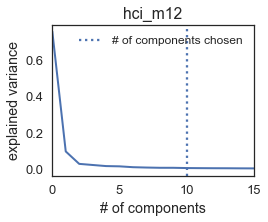

0.53219051818616636

In [74]:
run_pca_ols(items_12, 'hci_m12')

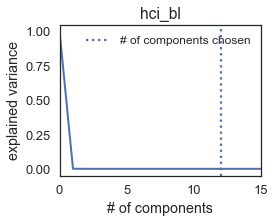

0.29178378989917653

In [71]:
run_pca_ols(items_bl, 'hci_bl')

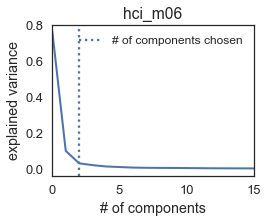

0.57356036718552561

In [57]:
run_pca_ols(items_06, 'hci_m06')